In [20]:
# imports
import glob
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram,stft
import matplotlib.pyplot as plt


import librosa
import librosa.display
%matplotlib inline

In [26]:
# Want to create a mel-Spectogram for a piece.
y, sr = librosa.load("../chopin/01 - 4 Ballades No.1 in G minor op.23.flac")
librosa.feature.melspectrogram(y=y, sr=sr)
# Using a pre-computed power spectrogram

D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D)
# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                    fmax=8000)

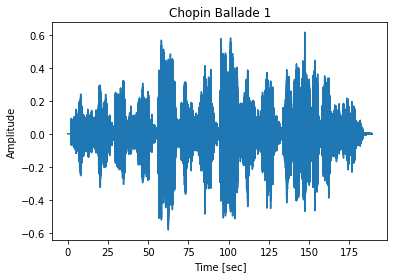

In [32]:
# duration in sec
T = float(len(y))/sr
# time vector
time = np.arange(0, T, 1./sr)
# plot time series
fig = plt.figure()
plt.plot(time,y)
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.title('Chopin Ballade 1')
plt.show()

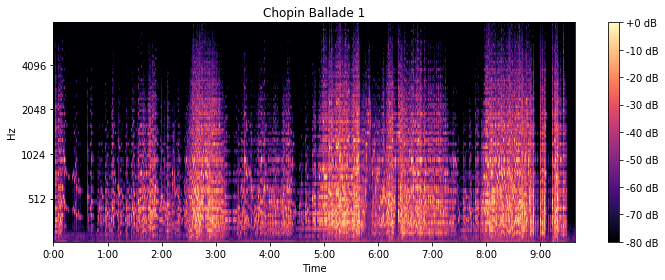

In [25]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,
                                             ref=np.max),
                         y_axis='mel', fmax=8000,
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Chopin Ballade 1')
plt.tight_layout()

In [27]:
# Want to create a mel-Spectogram for a piece.
y, sr = librosa.load("../chopin/mazurkas/01 - op. 6, No. 1 In F Sharp Minor.flac")
librosa.feature.melspectrogram(y=y, sr=sr)
# Using a pre-computed power spectrogram
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D)
# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                    fmax=8000)

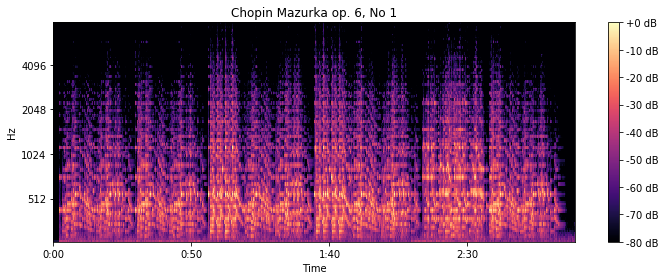

In [28]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,
                                             ref=np.max),
                         y_axis='mel', fmax=8000,
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Chopin Mazurka op. 6, No 1')
plt.tight_layout()